<a href="https://colab.research.google.com/github/brhie/ML-Algorithims-from-Scratch/blob/main/SVMfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

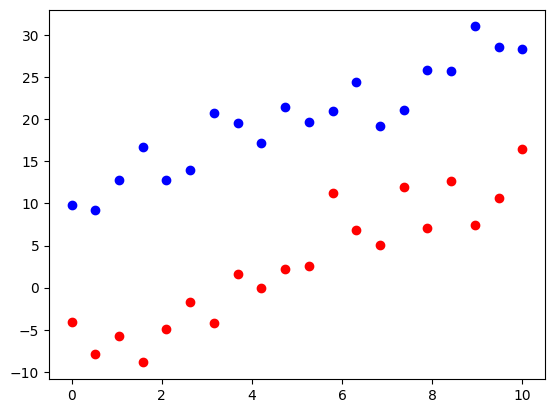

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

m = 20

fig, ax = plt.subplots()

x1 = np.linspace(0, 10, m)
x2_1 = 2.43 * x1 + 8.32 + np.random.randn(m) * 3
x2_0 = 2.43 * x1 - 8.45 + np.random.randn(m) * 3
y_1 = np.full(m, 1)
y_0 = np.full(m, -1)


ax.scatter(x1, x2_1, c="b")
ax.scatter(x1, x2_0, c="r")
plt.show()

In [ ]:
full_arr = np.concat((np.column_stack((x1, x2_1, y_1)), np.column_stack((x1, x2_0, y_0))))
full_arr

array([[ 0.00000000e+00,  9.81014246e+00,  1.00000000e+00],
       [ 5.26315789e-01,  9.18415446e+00,  1.00000000e+00],
       [ 1.05263158e+00,  1.28209604e+01,  1.00000000e+00],
       [ 1.57894737e+00,  1.67259317e+01,  1.00000000e+00],
       [ 2.10526316e+00,  1.27333293e+01,  1.00000000e+00],
       [ 2.63157895e+00,  1.40123260e+01,  1.00000000e+00],
       [ 3.15789474e+00,  2.07313227e+01,  1.00000000e+00],
       [ 3.68421053e+00,  1.95749358e+01,  1.00000000e+00],
       [ 4.21052632e+00,  1.71431558e+01,  1.00000000e+00],
       [ 4.73684211e+00,  2.14582064e+01,  1.00000000e+00],
       [ 5.26315789e+00,  1.97192206e+01,  1.00000000e+00],
       [ 5.78947368e+00,  2.09912318e+01,  1.00000000e+00],
       [ 6.31578947e+00,  2.43932552e+01,  1.00000000e+00],
       [ 6.84210526e+00,  1.92064751e+01,  1.00000000e+00],
       [ 7.36842105e+00,  2.10505097e+01,  1.00000000e+00],
       [ 7.89473684e+00,  2.58173479e+01,  1.00000000e+00],
       [ 8.42105263e+00,  2.57446645e+01

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

solvers.options["show_progress"] = False

def linear_kernel(X, Z):
    return X @ Z.T

def rbf_kernel(X, Z, gamma=1.0):
    X = np.atleast_2d(X)
    Z = np.atleast_2d(Z)
    X_norm = np.sum(X**2, axis=1)[:, None]
    Z_norm = np.sum(Z**2, axis=1)[None, :]
    sq_dists = X_norm + Z_norm - 2 * (X @ Z.T)
    return np.exp(-gamma * sq_dists)

def poly_kernel(X, Z, degree=3, gamma=1.0, coef0=1.0):
    X = np.atleast_2d(X)
    Z = np.atleast_2d(Z)
    return (gamma * (X @ Z.T) + coef0) ** degree

class SVMClassifier:
  def __init__(self, C=1.0, kernel='linear', **kernel_params):
    """
    C: soft-margin parameter
    kernel: 'linear', 'rbf', or 'poly'
    kernel_params: params for the kernel, e.g. gamma, degree, coef0
    """
    self.C = C
    self.kernel_name = kernel
    self.kernel_params = kernel_params
    self.alphas = None
    self.sv_X = None
    self.sv_y = None
    self.w = None
    self.b = None

  def _kernel(self, X, Z):
    if self.kernel_name == 'linear':
      return linear_kernel(X, Z)
    elif self.kernel_name == 'rbf':
      return rbf_kernel(X, Z, **self.kernel_params)
    elif self.kernel_name == 'poly':
      return poly_kernel(X, Z, **self.kernel_params)
    else:
      raise ValueError(f"Unknown kernel {self.kernel_name}")

  def fit(self, X, y):
    # X: NxD
    # y: N
    N, D = X.shape
    Y = np.diag(y)
    K = self._kernel(X, X)

    P = matrix(Y @ K @ Y, tc="d")
    q = matrix(- np.ones(N), tc="d")
    G_top = -np.eye(N)
    G_bottom = np.eye(N)
    G = matrix(np.vstack((G_top, G_bottom)), tc='d')

    h_top = np.zeros(N)
    h_bottom = self.C * np.ones(N)
    h = matrix(np.hstack((h_top, h_bottom)), tc='d')
    A = matrix(y.reshape(1, -1), tc="d")
    b = matrix(0.0)

    alphas = np.array(qp(P, q, G, h, A, b)["x"]).flatten()

    # Support vectors: α_i > 0
    eps = 1e-16
    sv_mask = alphas > eps
    self.alphas = alphas[sv_mask]
    self.sv_X = X[sv_mask]
    self.sv_y = y[sv_mask]

    if self.kernel_name == "linear":
      self.w = (self.alphas * self.sv_y) @ self.sv_X # shape: (D, )

    # b = y_k - sum_i α_i y_i K(x_i, x_k) averaged over k
    # Compute bias b using margin SVs: 0 < α_i < C

    margin_mask = (alphas > eps) & (alphas < self.C - eps)
    if np.any(margin_mask):
      idx = np.where(margin_mask)[0]
    else:
      # fallback: use all SVs if none strictly inside margin
      idx = np.where(sv_mask)[0]

    K_all_sv = self._kernel(X[idx], self.sv_X)  # shape (num_idx, num_sv)
    b_vals = []
    for n, k in enumerate(idx):
        decision_without_b = np.sum(self.alphas * self.sv_y * K_all_sv[n])
        b_vals.append(y[k] - decision_without_b)
    self.b = float(np.mean(b_vals))


  def decision_function(self, X):
    """
    Compute f(x) = sum_i α_i y_i K(x_i, x) + b
    """
    X = np.asarray(X, dtype=float)
    K_test = self._kernel(X, self.sv_X)  # (N_test, N_sv)
    return K_test @ (self.alphas * self.sv_y) + self.b

  def predict(self, X):
    return np.sign(self.decision_function(X))


In [ ]:
svm = SVMClassifier(kernel="linear", C=0.5)

svm.fit(full_arr[:, 0:2], full_arr[:, 2])
svm.w, svm.b

(array([-0.49894959,  0.31442425]), -1.098834885074254)

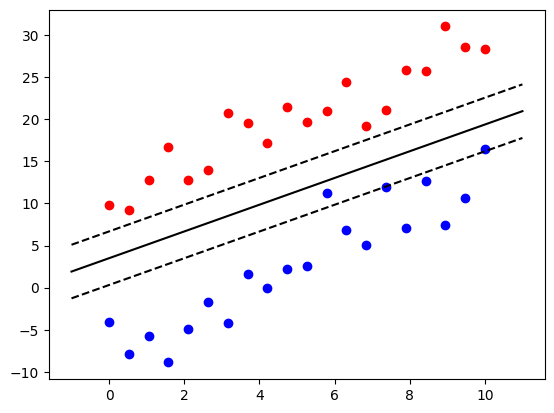

In [ ]:
fig, ax = plt.subplots()

idx_1 = full_arr[:, 2] == 1
idx_2 = full_arr[:, 2] == -1

# Create x-values for plotting
xmin, xmax = full_arr[:,0].min() - 1, full_arr[:,0].max() + 1
xs = np.linspace(xmin, xmax, 200)

# Formula: w1 * x + w2 * y + b = offset
# Solve for y = -(w1*x + b - offset) / w2

decision_boundary = -(svm.w[0] * xs + svm.b) / svm.w[1]
margin_pos        = -(svm.w[0] * xs + svm.b - 1) / svm.w[1]
margin_neg        = -(svm.w[0] * xs + svm.b + 1) / svm.w[1]


# Plot decision boundary & margins
ax.plot(xs, decision_boundary, 'k-',  label='Decision boundary')
ax.plot(xs, margin_pos,        'k--', label='+1 margin')
ax.plot(xs, margin_neg,        'k--', label='-1 margin')

ax.scatter(full_arr[idx_1][:, 0], full_arr[idx_1][:, 1], c="r")
ax.scatter(full_arr[idx_2][:, 0], full_arr[idx_2][:, 1], c="b")

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(full_arr[:, 2], svm.predict(full_arr[:, 0:2]))

1.0

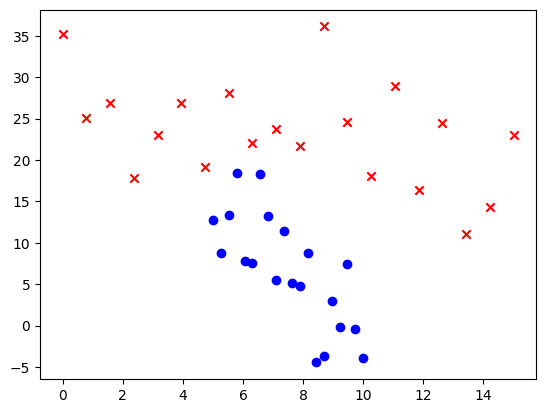

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

m = 20

fig, ax = plt.subplots()

x1_1 = np.linspace(5, 10, m)
x1_0 = np.linspace(0, 15, m)
x2_1 = np.sqrt(- x1_1 ** 2 + 120.32) + np.random.randn(m) * 6
x2_0 = np.sqrt(- x1_0 ** 2 + 700.32) + np.random.randn(m) * 6
y_1 = np.full(m, 1)
y_0 = np.full(m, -1)


ax.scatter(x1_1, x2_1, c="b", marker="o")
ax.scatter(x1_0, x2_0, c="r", marker="x")
plt.show()

In [ ]:
def polynomial(x1, x2, d, coef):
  return (x1 * x2 + coef) ** d

full_arr = np.concat((np.column_stack((x1_1, x2_1, y_1)), np.column_stack((x1_0, x2_0, y_0))))
full_arr

array([[ 5.        , 12.74348112,  1.        ],
       [ 5.26315789,  8.79429953,  1.        ],
       [ 5.52631579, 13.36135333,  1.        ],
       [ 5.78947368, 18.45493793,  1.        ],
       [ 6.05263158,  7.74306592,  1.        ],
       [ 6.31578947,  7.56350047,  1.        ],
       [ 6.57894737, 18.25237502,  1.        ],
       [ 6.84210526, 13.17814881,  1.        ],
       [ 7.10526316,  5.53990158,  1.        ],
       [ 7.36842105, 11.38102154,  1.        ],
       [ 7.63157895,  5.0985168 ,  1.        ],
       [ 7.89473684,  4.82094355,  1.        ],
       [ 8.15789474,  8.78449164,  1.        ],
       [ 8.42105263, -4.45075036,  1.        ],
       [ 8.68421053, -3.64842592,  1.        ],
       [ 8.94736842,  2.971714  ,  1.        ],
       [ 9.21052632, -0.11995684,  1.        ],
       [ 9.47368421,  7.41443575,  1.        ],
       [ 9.73684211, -0.39701529,  1.        ],
       [10.        , -3.96605114,  1.        ],
       [ 0.        , 35.25745246, -1.   

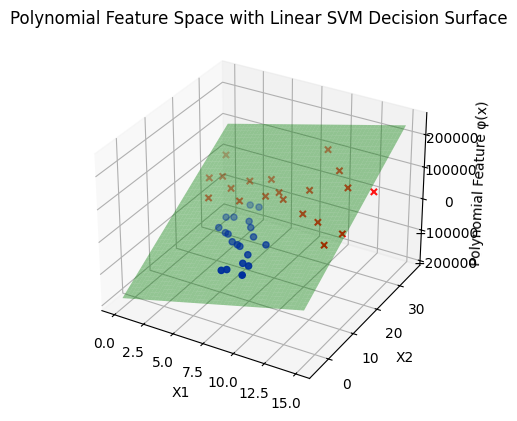

In [130]:
# Your polynomial feature and training
z = polynomial(full_arr[:, 0], full_arr[:, 1], d=2, coef=1.0)
poly_mat = np.insert(full_arr, [2], z.reshape(-1, 1), axis=1)
svm = SVMClassifier(kernel="linear")
svm.fit(poly_mat[:, 0:3], poly_mat[:, 3])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot data
idx_1 = poly_mat[:, 3] == 1
idx_0 = poly_mat[:, 3] == -1

ax.scatter(poly_mat[idx_1][:, 0],
           poly_mat[idx_1][:, 1],
           poly_mat[idx_1][:, 2],
           c="b", marker="o")
ax.scatter(poly_mat[idx_0][:, 0],
           poly_mat[idx_0][:, 1],
           poly_mat[idx_0][:, 2],
           c="r", marker="x")

# --------------------------
# ADD DECISION SURFACE
# --------------------------
w = svm.w        # shape (3,)
b = svm.b        # scalar

# Create a grid over x1, x2
x1_range = np.linspace(poly_mat[:,0].min(), poly_mat[:,0].max(), 50)
x2_range = np.linspace(poly_mat[:,1].min(), poly_mat[:,1].max(), 50)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Compute decision surface z for f(x) = 0
# z = -(w1*x1 + w2*x2 + b) / w3
W1, W2, W3 = w
Z = -(W1 * X1 + W2 * X2 + b) / W3

# Plot decision plane
ax.plot_surface(X1, X2, Z, alpha=0.4, color='green')

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("Polynomial Feature φ(x)")

plt.title("Polynomial Feature Space with Linear SVM Decision Surface")
plt.show()